In [1]:
import numpy as np
from numpy import r_
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure,plot, title,stem, loglog,xlabel,ylabel
import bitarray, time, urllib, ssl
from scipy import signal, integrate
#from math import gcd
from fractions import gcd
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign
from scipy import misc
import serial
import sounddevice as sd
import threading
import time 
import queue
from compressor import *
%matplotlib inline

## Function Definitions: Modulation and Demodulation

In [2]:
def lcm(numbers):
    return reduce(lambda x,y: (x*y)//gcd(x,y), numbers, 1)

def afsk1200(bits, fc=3000, df=600, baud=2400, fs=48000):
    fs_eff = lcm((fs, baud))
    bit_length = fs_eff//baud #Each bit's duration is the sampling rate (samples/s) / (bits/s) => samples/bit
    num_samples = bit_length * len(bits) #The total number of samples is the bit length * # bits
    tot_time = num_samples/fs_eff #converts samples to time using sample rate
    #change the bitstream to be between -1 and 1 instead of 0 and 1
    m = np.zeros(num_samples)
    #Expands the bitstream to its full length, basically inserting bit_length copies of each bit into the stream
    cur_idx = 0
    for bit in bits:
        for i in range(0, bit_length): 
            if bit == 1:
                m[cur_idx] = bit
            if bit == 0 or bit == -1:
                m[cur_idx] = -1
            cur_idx += 1
    t = np.linspace(0, tot_time, num_samples) #time indices for the inte gration
    func = lambda time: m[time]
    integrated = np.array(integrate.cumtrapz(m, t, initial=0)) #integrat es over m to ensure smooth frequency transitions
    sig = np.cos(2*np.pi*fc*t + 2*np.pi*df*integrated) #The actual si gnal is a series of cosines at 1200 Hz and 2200 Hz
    sig = sig[::fs_eff//fs] 
    return sig

def nc_afsk2400Demod(sig, fc=3000, df=600, baud=2400, fs=48000, TBW=2):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 2400
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    TBW = 2.0
    N = (int((fs/baud*TBW)/2))*2+1 
    BW = baud     
    
    h_lp = signal.firwin(N, BW/fs*1.0,window='hanning')
    h_lpp = signal.firwin(N, BW*2*1.2/fs,window='hanning')
    h_space = h_lp*exp(1j*2*pi*(fc + df)*(r_[0:N]-N//2)/fs)
    h_mark = h_lp*exp(1j*2*pi*(fc - df)*(r_[0:N]-N//2)/fs)
    h_bp = signal.firwin(N, BW/fs*2.2,window='hanning')*exp(1j*2*pi*fc*(r_[0:N]-N//2)/fs)
    
    sig = np.convolve(sig,h_bp,mode='valid')
    nrz = -abs(np.convolve(sig,h_mark,mode='valid')) + abs(np.convolve(sig,h_space,mode='valid'))
    nrz = np.convolve(nrz,h_lpp,mode='valid')
    return nrz

def PLL(NRZa, init_pll = 0, a = 0.74 , fs = 48000, baud = 2400): 
    # function implements a simple phased lock loop for tyming recovery
    #
    # Inputs:
    #          NRZa -   The NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    # idx - array of indexes to sample at #
    tick = (2**32)//(fs//baud)
    pll = np.int32(init_pll)
    idx = []
    for i in range(0, len(NRZa)):
        if i != 0 and np.sign(NRZa[i-1]) != np.sign(NRZa[i]): #zero cros
            pll = np.int32(pll * a)
        tmp = pll
        pll = np.int32(np.int32(pll)+np.int32(tick)) 
        if (pll < tmp):
            idx.append(i) #this is a sample since the pll has overflowed
    bits =  bitarray.bitarray((NRZa[idx]>0).tolist())
    return bits, idx, pll

def serialize_Queue(q):
    sig = np.array([])
    while not q.empty():
        sig = np.append(sig, q.get())
    return sig

## Class Definitions: the threads

In [3]:
class demodder(threading.Thread):
    def __init__(self, threadID, name, bitsQueue, soundQueue, fc, df, baud, fs):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.exit_flag = 0
        self.bitsQueue = bitsQueue
        self.soundQueue = soundQueue
        self.fc = fc
        self.df = df
        self.baud = baud
        self.fs = fs
        
    def run(self):
        print ("Starting " + self.name)
        self.demod_audio(self.name)
        print ("Exiting " + self.name)
        return 
    
    def demod_audio(self, threadName):
        pll = 0 
        while not self.bitsQueue.full():
            if not self.soundQueue.empty():
#                 print("Got audio chunk! demodding...")
                chunk = self.soundQueue.get()
                nrz = nc_afsk2400Demod(chunk, fc=self.fc, df=self.df, baud=self.baud, fs=self.fs)
                bits, idx, pll = PLL(nrz, pll, fs=self.fs, baud=self.baud)
                bits = np.array(bits, dtype = int)
                self.bitsQueue.put(bits) 
            if self.exit_flag == 1:
                break
        return 

# Packet Layer 

## Utility Functions

In [4]:
def crc8(x, encode = True):
#     crc polynomial = x^8 + x^5 + x^4 + 1
#  assumes MSB
    message_len = len(x) 
    div_stop = message_len  - 8
    crc_poly = np.zeros(9, dtype = bool)
    crc_poly[0], crc_poly[3], crc_poly[4], crc_poly[8] = True, True, True, True
    y = np.array(x)
    if(encode):
        #     append with the remainder bits
        y = np.append(x, np.zeros(8, dtype = bool))
        div_stop = message_len
    i = 0
    
    while i < div_stop and y[0:message_len].any():
        if y[i]:
            y[i:i+9] = np.logical_xor(y[i:i+9], crc_poly)
        i += 1
    return np.array(y[len(y) - 8:], dtype = int)
def crc16(x, encode = True):
#     crc polynomial = x^16 + x^15 + x^2 + 1 CRC-16-IBM
#  assumes MSB
    message_len = len(x) 
    div_stop = message_len  - 16
    crc_poly = np.zeros(17, dtype = int)
    crc_poly[0], crc_poly[1], crc_poly[15], crc_poly[16] = 1, 1, 1, 1
    y = np.array(x)
    if(encode):
        #     append with the remainder bits
        y = np.append(x, np.zeros(16, dtype = int))
        div_stop = message_len
    i = 0
    
    while i < div_stop and np.sum(y[0:message_len]) > 0:
        if y[i]:
            y[i:i+17] = gf2_add(y[i:i+17], crc_poly)
        i += 1
    return np.array(y[len(y) - 16:])

# assumes that said bits have the crc as the last 16 bits
def check_crc16_valid(bits):
    check = np.sum(crc16(bits))
    if (check == 0):
        return True
    
    return False
    
def lcm(numbers):
    return reduce(lambda x,y: (x*y)//gcd(x,y), numbers, 1)

def int_to_bit_arr(num, size):
    assert 2**size > num
    b_arr = np.zeros(size, dtype = int)
    div = 2**(size - 1)
    for i in range(size):
        b_arr[i] = num//div
        num -= b_arr[i] * div
        div = div//2
    return b_arr

def bit_array_to_int(bit_arr):
    size = len(bit_arr)
    num = np.int(0)
    p = 2**(size - 1)
    for digit in bit_arr:
        num += digit*p
        p = p//2
    return int(num)

# function to encode a image nxmx3 uint8 arrray 
def img_to_bit_arr(img):
    image_h = img.shape[0]
    image_w = img.shape[1]
    bit_arr = np.zeros(image_h*image_w*3*8, dtype = int)
    for i in range(image_h):
        for j in range(image_w):
            curr_pixel = i*image_w + j
            chunk = np.concatenate((int_to_bit_arr(img[i][j][0],8), int_to_bit_arr(img[i][j][1],8), int_to_bit_arr(img[i][j][2],8)))
#             print(chunk)
            bit_arr[curr_pixel*24:curr_pixel*24 + 24] = chunk
    return bit_arr

def gf2_add(a, b):
    assert len(a) == len(b)
    mod_arr = 2 * np.ones(len(a))
    return np.mod(a+b, mod_arr).astype(int)

def PRBS9(n):
#     MSB cause I don't care
    out = np.zeros(n, dtype = int)
    register = np.zeros(9, dtype = int)
    register[0], register[3], register[8] = 1, 1, 1 #arbitrary as balls
    
    for i in range(n):
        out[i] = register[0]
        new_bit = (register[4] + register[0]) % 2
        register = np.roll(register, -1)
        register[8] = new_bit
    
    return out

## Packet Class

In [5]:
class Packet:
    num_size = 10
    data_len = 64*8
    preamble = np.array([0,1,1,1,1,1,1,0]) #generated from random.org
    preamble = np.concatenate((preamble, preamble))
    bit_len = len(preamble) + num_size + data_len + 16
    whiten_code = PRBS9(bit_len - len(preamble))
    
    def __init__(self):
        self.num_size = 10
        self.packet_num = 0
        self.packet_num_bits = np.zeros(Packet.num_size) #field for packet number. important for FEC
        self.data = np.zeros(Packet.data_len)
        self.checksum = np.zeros(16)
        self.crc_valid = False
    
    def init_from_tx_data(self, packet_num, data_bits):
#         best effort attempt to recover bits 
        n = min(len(data_bits), Packet.data_len)
        for i in range(n):
            self.data[i] = data_bits[i]
        self.packet_num = packet_num
        self.packet_num_bits = int_to_bit_arr(self.packet_num, Packet.num_size)
        
        self.checksum = crc16(np.concatenate((self.packet_num_bits, self.data)))
        self.crc_valid = True
    
    def set_packet_num(self, packet_num):
        self.packet_num = packet_num
        self.packet_num_bits = int_to_bit_arr(self.packet_num, Packet.num_size)
        
        self.checksum = crc16(np.concatenate((self.packet_num_bits, self.data)))
        self.crc_valid = True
# assumes that the rx_bits DON"T include the preamble bits
#  also assumes that the rx_bits have the correct length
    def init_from_rx_bits(self, rx_bits):
        rx_bits = gf2_add(Packet.whiten_code, rx_bits)
        self.packet_num = bit_array_to_int(rx_bits[0:Packet.num_size])
        self.data = rx_bits[Packet.num_size:Packet.num_size + Packet.data_len]
        self.checksum = rx_bits[Packet.data_len + Packet.num_size:]
        self.crc_valid = check_crc16_valid(rx_bits)
    
    def gen_bits(self):
        msg_bits = np.concatenate((self.packet_num_bits, self.data, self.checksum))
#         whiten the data 
        msg_bits = gf2_add(msg_bits, Packet.whiten_code)
        return np.concatenate((Packet.preamble, msg_bits))

## Stream Packet Decoder


In [6]:
# FIFO ring buffer
# lower index is "front" 
class RingBuff():
    def __init__(self, size):
        self.data = np.ones(size, dtype = int) * -1
        self.size = size
    
    def push(self, val):
        self.data = np.roll(self.data, -1)
        self.data[-1] = val
    
    def peek(self):
        return self.data[0]

# class that interfaces with a incoming bit buffer, detects packets, and dumps em out
# packet len is packet length without the preamble
# state 0: no packet detected | check recieve buffer 
# state 1: packet preamble detected | dump bits into output buffer
# state 2: output buffer filled | make a packet out of the output buffer | transition to state 0 
class Pacman():
    ## preamble : numpy.array : ints that represents the packet preamble
    ## packet_len : int : length of packet, excluding the preamble
    def __init__(self, preamble, packet_len):
        self.input_buffer = RingBuff(len(preamble))
        self.preamble = np.copy(preamble)
        self.output_buffer = np.zeros(packet_len)
        self.counter = 0
        self.state = 0
        self.output_size = packet_len
        self.output_packet_q = queue.Queue()
    
    def process_bit(self, bit_in):
        if (self.state == 0):
#             print("dude")
#             print(self.input_buffer.data)
            self.input_buffer.push(bit_in)
#             now check if a preamble has been detected
            if (np.array_equal(self.input_buffer.data, self.preamble)):
                self.state = 1
                self.counter = 0 
#                 flush the input buffer
                print("packet detected")
                for _ in range(self.input_buffer.size):
                    self.input_buffer.push(bit_in)
        elif (self.state == 1):
            self.output_buffer[self.counter] = bit_in
            self.counter += 1
            if (self.counter >= self.output_size):
                self.counter = 0
                self.state = 2 # yeah I know this is not necessary
#                 make a new packet
                pkt = Packet()
                pkt.init_from_rx_bits(self.output_buffer)
                self.output_packet_q.put(pkt)
                self.state = 0
                print("packet received")
        else:
            print("Warning: Invalid state")

def avgPS( x, N=256, fs=1):
    M = int(len(x)//N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return np.r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X**2),axis=0)


def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=plt.figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    

    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
        print(1)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

## data packetization 

In [7]:
# packet 0 will always be a header packet
# data: |total length of payload in bits (32 bit int)|total number of packets being sent (10 bits)| alternating 1 0 sequence
# we'll also assume if the packet is numbered 2^Packet.num_size - 1 it's the stop packet / last packet

# packetize the databits into a bit stream that can be tx_ed 
def packetize_msg(msg_bits):
    msg_len = len(msg_bits)
    num_packets =int(np.ceil(msg_len/Packet.data_len)) #round up.
    tx_bits = np.array([1, 0, 1, 0, 1, 0, 1, 0], dtype = int) #PLL lock prefix
    for i in range(1):
        tx_bits = np.concatenate((tx_bits, [1, 0, 1, 0, 1, 0, 1, 0]))
    
#     construct the fist header bit
    packet_data = np.zeros(Packet.data_len)

    packet_data[0:32] = int_to_bit_arr(msg_len, 32)
    #print(num_packets)
    packet_data[32:32 + 10] = int_to_bit_arr(num_packets, Packet.num_size)
#     now fill the rest with data to make the PLL happy
    temp = 0
    for i in range(32+10, Packet.data_len):
        packet_data[i] = temp
        temp = (temp + 1) % 2
    pkt = Packet()
    pkt.init_from_tx_data(0, packet_data)
    #we're gonna add the start packet twice
    tx_bits = np.concatenate((tx_bits, pkt.gen_bits()))
    tx_bits = np.concatenate((tx_bits, pkt.gen_bits()))
    
    for i in range(1, num_packets + 1):
        start = (i - 1)*Packet.data_len
        end = i * Packet.data_len
        pkt = Packet()
        
        if (end > msg_len):
            end = msg_len
            packet_data = np.zeros(Packet.data_len)
            packet_data[0:end-start] = msg_bits[start:end]
            temp = 0
            for j in range(end - start, Packet.data_len):
                packet_data[j] = temp
                temp = (temp + 1) % 2
            pkt.init_from_tx_data(i, packet_data)
            
        else : 
            pkt.init_from_tx_data(i, msg_bits[start:end])
        
#         if last packet add the stop sequence
        if (i == num_packets):
            pkt.set_packet_num(2**Packet.num_size - 1)
            tx_bits = np.concatenate((tx_bits, pkt.gen_bits()))
        
        #we're also going to send the end sequence twice
        tx_bits = np.concatenate((tx_bits, pkt.gen_bits()))
        
    return tx_bits 

# packets is a python list with, well, all this packets
# return data and packets with crc_errors
def recover_msg(packets):
# #     really lazy right now and no-error correct is being implemented
#     header_data = packets[0].data
#     msg_len = bit_array_to_int(header_data[0:32])
#     num_packets = bit_array_to_int(header_data[32:32+10])
    
# #     print(num_packets)
    
#     rcv_msg = np.zeros(msg_len)
#     packet_errors = 0
    
#     for i in range(1, num_packets + 1):
#         start = (i - 1)*Packet.data_len
#         end = i * Packet.data_len
        
#         if(end > msg_len):
#             end = msg_len
        
#         rcv_msg[start:end] = packets[i].data[0:end - start]
#         if(not packets[i].crc_valid):
#             packet_errors += 1
    packet_errors = 0 
    rcv_msg = None
    msg_len = 0
    num_packets = 0
    stop_val = 2**Packet.num_size - 1
#     first compute the number of crc errors
    for p in packets:
        if not p.crc_valid:
            packet_errors += 1
#     look for the starter packets
    found_valid_start = False
    
    for p in packets:
        if p.packet_num == 0 and p.crc_valid:
            found_valid_start = True
            header_data = p.data
            msg_len = bit_array_to_int(header_data[0:32])
            print("Message Length: " + str(msg_len))
            num_packets = bit_array_to_int(header_data[32:32+10]) + 1 #account for header
            break
    
    if (not found_valid_start):
        print("Error, no valid start packet found")
        return rcv_msg, packet_errors

    rcv_msg = np.zeros(msg_len, dtype = int)
    recovered_packets = np.zeros(num_packets, dtype = int)
    recovered_packets[0] = 1
#     first stage, go through and only fill valid packets
    for p in packets: 
#         check if it's an end packet
        if (p.packet_num == stop_val and p.crc_valid and recovered_packets[num_packets - 1] == 0):
            # junk
            start = (num_packets - 2)*Packet.data_len
#             print(msg_len - start)
            rcv_msg[start:msg_len] = p.data[0:msg_len - start]
            recovered_packets[num_packets - 1] = 1
#         sanity check the packet_num
        if (p.packet_num < num_packets and p.packet_num > 0):
            if (p.crc_valid and recovered_packets[p.packet_num] == 0):
                start = (p.packet_num - 1)*Packet.data_len
                end = start + Packet.data_len
                rcv_msg[start:end] = p.data
                recovered_packets[p.packet_num] = 1
    
#     second stage, don't check crc this time since we might need the data
    for p in packets: 
#         check if it's an end packet
        if (p.packet_num == stop_val and recovered_packets[num_packets - 1] == 0):
            # junk
            start = (num_packets - 2)*Packet.data_len
#             print(msg_len - start)
            rcv_msg[start:msg_len] = p.data[0:msg_len - start]
            recovered_packets[num_packets - 1] = 0
#         sanity check the packet_num
        if (p.packet_num < num_packets and p.packet_num > 0):
            if (recovered_packets[p.packet_num] == 0):
                start = (p.packet_num - 1)*Packet.data_len
                end = start + Packet.data_len
                rcv_msg[start:end] = p.data
                recovered_packets[p.packet_num] = 1
    
    return rcv_msg, packet_errors

#Transmitter 

In [8]:
fs = 48000
baud = 2400
fc = 3000
df = 600

##Initalize the serial port to key the radio

In [11]:
port = serial.Serial('/dev/tty.SLAB_USBtoUART')
port.setDTR(False)
time.sleep(1)
port.setDTR(True)

In [10]:
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)

##Generates a sine wave for gain calibration on the rx side

In [9]:
usb_idx = 2
t = np.linspace(0,10,fs*10)
sig_tx = np.sin(2*np.pi*2400*t)

10.0


##Load the image

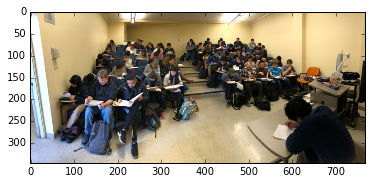

In [9]:
fname = '../images/mid_test.tiff'
g = False
if g: 
    image = misc.imread(fname, flatten=True)
    plt.imshow(image,cmap="gray")
else:
    image = misc.imread(fname)
    plt.imshow(image)
plt.show()

##Compress and modulate the image, calculate estimated PSNR and TX time

In [10]:
#Select the optimal  based on what kind of image it is 
#compressed = downsampled_compress(image, ds=4.0)
#compressed = binary_compressor(image)
compressed = compress(image, out_bits=8)

#plt.imshow(decompress(compressed))
#plt.imshow(downsampled_decompress(compressed, ds=4.0), cmap="gray")
#print("psnr", EE123_psnr(binary_decompressor(compressed), image))
print("psnr", EE123_psnr(decompress(compressed), image))

msg_data_pkt = packetize_msg(compressed)
#msg_data_pkt = packetize_msg(img_to_bit_arr(image)[0:16384])
print(len(msg_data_pkt))
sig_tx = np.concatenate((np.zeros(0.25 * fs), afsk1200(msg_data_pkt, fc=fc, df=df, baud=baud, fs = fs), np.zeros(0.25 * fs)))
print(len(sig_tx)/fs)

(346, 768)
Coeffs Shape: (176, 387) [(176, 387), (176, 387), (176, 387)]
Coeffs Shape: (91, 197) [(91, 197), (91, 197), (91, 197)]
Coeffs Shape: (49, 102) [(49, 102), (49, 102), (49, 102)]
2225192
(43, 96)
Coeffs Shape: (25, 51) [(25, 51), (25, 51), (25, 51)]
Coeffs Shape: (16, 29) [(16, 29), (16, 29), (16, 29)]
Coeffs Shape: (11, 18) [(11, 18), (11, 18), (11, 18)]
2273584
(43, 96)
Coeffs Shape: (25, 51) [(25, 51), (25, 51), (25, 51)]
Coeffs Shape: (16, 29) [(16, 29), (16, 29), (16, 29)]
Coeffs Shape: (11, 18) [(11, 18), (11, 18), (11, 18)]
2321976
decode called
image_shape (346, 768)
(176, 387)
(176, 387)
(176, 387)
image_shape (346, 768)
(91, 197)
(91, 197)
(91, 197)
image_shape (346, 768)
(49, 102)
(49, 102)
(49, 102)
(49, 102)
decode called
image_shape (43, 96)
(25, 51)
(25, 51)
(25, 51)
image_shape (43, 96)
(16, 29)
(16, 29)
(16, 29)
image_shape (43, 96)
(11, 18)
(11, 18)
(11, 18)
(11, 18)
decode called
image_shape (43, 96)
(25, 51)
(25, 51)
(25, 51)
image_shape (43, 96)
(16, 29)


##Key the radio and send the signal

In [31]:
port.setDTR(False)
time.sleep(1)
sd.play(sig_tx*0.75, samplerate=fs, blocking=True)
time.sleep(0.5)
port.setDTR(True)

In [29]:
port.setDTR(False)

In [25]:
port.setDTR(True)